In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.decomposition import PCA

from torch_linregr import *

# Integrating CPHS Data and Code

## Load Data

In [2]:
import pickle

with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block1.pickle", 'rb') as handle:
    #refs_block1, poss_block1, dec_vels_block1, int_vel_block1, emgs_block1, Ws_block1, Hs_block1, alphas_block1, pDs_block1, times_block1, conditions_block1 = pickle.load(handle)
    refs_block1, _, _, _, emgs_block1, _, _, _, _, _, _ = pickle.load(handle)

#with open(r"C:\Users\kdmen\Desktop\Research\personalization-privacy-risk\Data\continuous_full_data_block2.pickle", 'rb') as handle:
#    #refs_block2, poss_block2, dec_vels_block2, int_vel_block2, emgs_block2, Ws_block2, Hs_block2, alphas_block2, pDs_block2, times_block2, conditions_block2 = pickle.load(handle)
#    refs_block2, _, _, _, emgs_block2, _, _, _, _, _, _ = pickle.load(handle)

In [3]:
keys = ['METACPHS_S106', 'METACPHS_S107', 'METACPHS_S108', 'METACPHS_S109', 'METACPHS_S110', 'METACPHS_S111', 'METACPHS_S112', 'METACPHS_S113', 'METACPHS_S114', 'METACPHS_S115', 'METACPHS_S116', 'METACPHS_S117', 'METACPHS_S118', 'METACPHS_S119']
num_conds = 8
num_channels = 64
num_updates = 19
cphs_starting_update = 10
update_ix = [0,  1200,  2402,  3604,  4806,  6008,  7210,  8412,  9614, 10816, 12018, 13220, 14422, 15624, 16826, 18028, 19230, 20432, 20769]

In [4]:
lambdaF = 0
lambdaD = 1e-10
lambdaE = 1e-6
lambdasFDE=[lambdaF, lambdaD, lambdaE]

learning_rate = 0.0001

In [5]:
print("Condition 1")
F1tens_full = torch.from_numpy(emgs_block1[keys[0]][0, :, :]).type(torch.float32)
PREF1tens_full = torch.from_numpy(refs_block1[keys[0]][0, :, :]).type(torch.float32)

print(f"EMG Input size: {F1tens_full.size()}")
print(f"2D Velocity Label size: {PREF1tens_full.size()}")

Condition 1
EMG Input size: torch.Size([20770, 64])
2D Velocity Label size: torch.Size([20770, 2])


## PyTorch Linear Regression With Full Dataset

In [6]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

total_epochs_FullData = 500

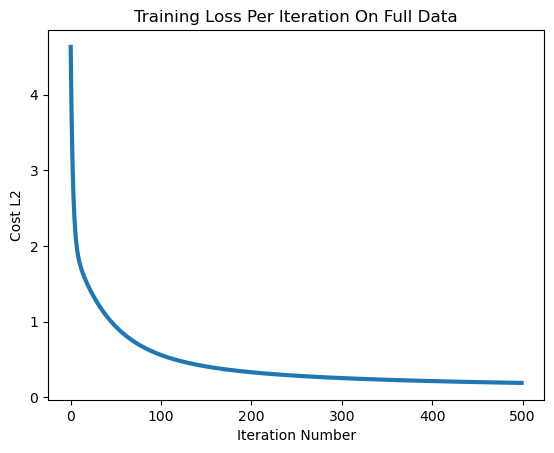

In [7]:
num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

# Other option which should give same result:
untrained_model_FullData = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FullData.parameters(), lr=learning_rate)

trained_model_FullData, loss_log_FullData = full_train_linregr_updates(untrained_model_FullData, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=total_epochs_FullData, lambdasFDE=[lambdaF, lambdaD, lambdaE], stream_data_updates=False, use_full_input_data=True, normalize_V=True, starting_update=0)

plt.plot(range(len(loss_log_FullData)), loss_log_FullData, linewidth=3)
plt.title("Training Loss Per Iteration On Full Data")
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## PyTorch Linear Regression With Streamed Data

In [8]:
num_updates = 19
starting_update = 0
normalize_emg = False
pca_channel_default = 64
PCA_comps = 64

input_size = num_input_channels
output_size = 2  # 2D Velocity

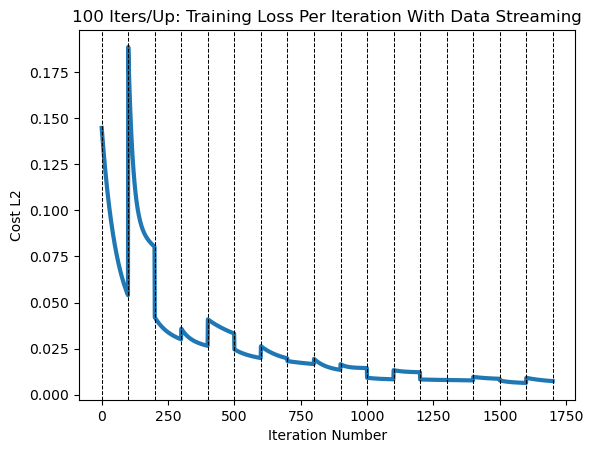

In [9]:
num_iters_per_update = 100

num_input_channels = 64  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

untrained_model_NoFL = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_NoFL.parameters(), lr=learning_rate)

trained_model_NoFL, loss_log_NoFL = full_train_linregr_updates(untrained_model_NoFL, F1tens_full, PREF1tens_full, learning_rate, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_V=True, num_iters_per_update=num_iters_per_update, starting_update=0)

plt.plot(range(len(loss_log_NoFL)), loss_log_NoFL, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Data Streaming")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

## Redo but with FL Data Processing Turned On

In [10]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = True
pca_channel_default = 64
PCA_comps = 7

# BUILD MODEL
num_input_channels = PCA_comps 
input_size = num_input_channels
# ^ IRL I'm not sure we are guaranteed to get equalength trials
#  Thus may be better to do every time point individually? Not sure
output_size = 2  # 2D Velocity

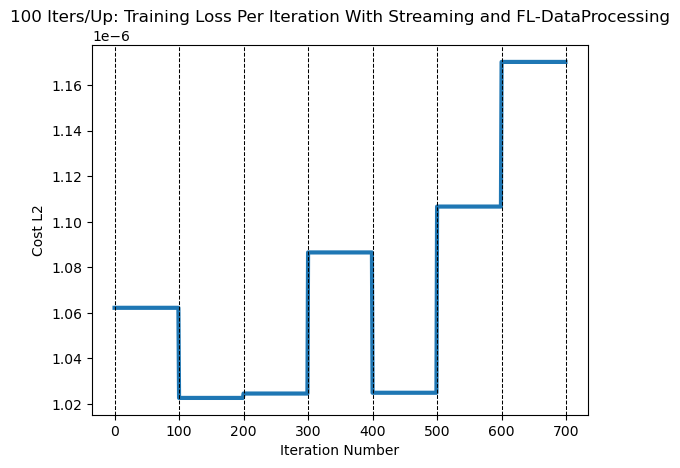

In [11]:
num_iters_per_update=100

untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, lambdasFDE=[lambdaF, lambdaD, lambdaE], starting_update=10, normalize_V=True, normalize_emg=True, PCA_comps=7, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("100 Iters/Up: Training Loss Per Iteration With Streaming and FL-DataProcessing")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()

Investigating why the above code is trash with static cost functions

Don't Normalize EMG but do use PCA

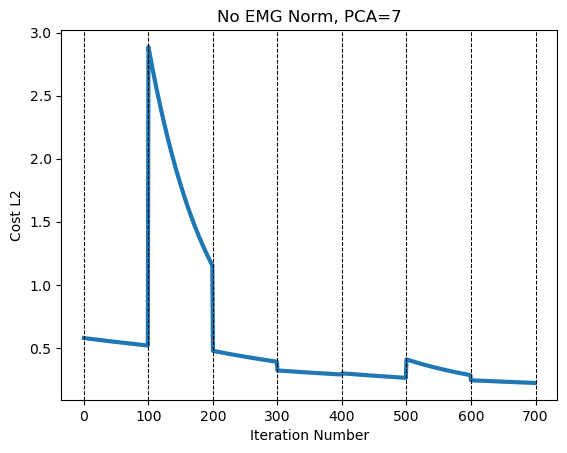

In [12]:
# PARAMS
num_updates = 9
starting_update = 10
normalize_emg = False
pca_channel_default = 64
PCA_comps = 7

#######################################################################

num_iters_per_update=100

num_input_channels = PCA_comps  # Change once I add PCA
input_size = num_input_channels
output_size = 2  # 2D Velocity

untrained_model_FLDP100 = torch.nn.Linear(input_size, output_size)  # Single layer nn for Lin Regr
optimizer = torch.optim.SGD(untrained_model_FLDP100.parameters(), lr=learning_rate)

trained_model_FLDP100, loss_log_FLDP100 = full_train_linregr_updates(untrained_model_FLDP100, F1tens_full, PREF1tens_full, learning_rate, num_iters_per_update=num_iters_per_update, normalize_V=True, starting_update=10, lambdasFDE=[lambdaF, lambdaD, lambdaE], normalize_emg=normalize_emg, PCA_comps=PCA_comps, loss_log=[])

plt.plot(range(len(loss_log_FLDP100)), loss_log_FLDP100, linewidth=3)
plt.title("No EMG Norm, PCA=7")
update_advancement_idxs = range(0,num_iters_per_update*(num_updates-1), num_iters_per_update)
for i in update_advancement_idxs:
    plt.axvline(i, linewidth=0.75, linestyle='--', color='black')
plt.xlabel('Iteration Number')
plt.ylabel('Cost L2')
plt.show()